In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from model import *

EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.001
MODEL = 'RNN'
INPUT_CHANNELS = 1
OUTPUT_SIZE = 10

In [2]:

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# load training sets, split the dataset into training and validation sets
_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(_trainset))
val_size = len(_trainset) - train_size
trainset, valset = data.random_split(_trainset, [train_size, val_size])

trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# load test set
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print('shape:', testset.data.shape)
print(next(testloader.__iter__())[0].shape)
#print(torchvision.datasets.CIFAR10.classes)
#plt.imshow(testset.data[10], cmap='gray')

shape: torch.Size([10000, 28, 28])
torch.Size([256, 1, 28, 28])


In [3]:
# Step 2: Define the CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 将图像数据转换为序列

image_width = _trainset.data.shape[1]
if MODEL == 'CNN':
    net = CNN(input_channels=INPUT_CHANNELS, output_size=OUTPUT_SIZE).to(device)
elif MODEL == 'RNN':
    net = RNN(image_width, OUTPUT_SIZE,
            hidden_size=128, num_layers=1).to(device)
elif MODEL == 'MLP':
    net = MLP([image_width*image_width*INPUT_CHANNELS, INPUT_CHANNELS*256, 
               INPUT_CHANNELS*64, 10]).to(device)
elif MODEL == 'RNN_ATTN':
    net = RNN_ATTN(input_size=image_width, hidden_size=64, output_size=OUTPUT_SIZE).to(device)
else:
    raise ValueError('Model not supported: {}'.format(MODEL))


print(net)

CNN(
  (cnnBlock1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnnBlock2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=10, bias=True)
)


c:\Users\youfeng\miniconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:

# Step 3: Define the loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


In [5]:
# Step 4: Train the model
num_epochs = EPOCHS
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0  # 用于跟踪最佳验证准确率

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_total = 0
    val_total = 0
    train_correct = 0
    val_correct = 0

    # Training
    net.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validation
    net.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    train_loss /= len(trainloader)
    val_loss /= len(valloader)
    train_acc = 100.0 * train_correct / train_total
    val_acc = 100.0 * val_correct / val_total

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 保存最佳模型
    import os
    checkpoints_dir = "./checkpoints"
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    dataset_name = _trainset.__class__.__name__
    best_model_path = f"./checkpoints/{MODEL}_{dataset_name}_BZ{BATCH_SIZE}.pth"
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_net = net.cpu()
        torch.save(save_net, best_model_path)

Epoch 1/15: Train Loss: 0.5322, Train Acc: 80.64%, Val Loss: 0.3787, Val Acc: 86.51%
Epoch 2/15: Train Loss: 0.3388, Train Acc: 87.75%, Val Loss: 0.3131, Val Acc: 88.70%
Epoch 3/15: Train Loss: 0.2894, Train Acc: 89.52%, Val Loss: 0.2919, Val Acc: 89.25%
Epoch 4/15: Train Loss: 0.2586, Train Acc: 90.64%, Val Loss: 0.2612, Val Acc: 90.60%
Epoch 5/15: Train Loss: 0.2309, Train Acc: 91.50%, Val Loss: 0.2479, Val Acc: 91.15%
Epoch 6/15: Train Loss: 0.2127, Train Acc: 92.19%, Val Loss: 0.2361, Val Acc: 91.54%
Epoch 7/15: Train Loss: 0.1918, Train Acc: 93.06%, Val Loss: 0.2192, Val Acc: 91.88%
Epoch 8/15: Train Loss: 0.1723, Train Acc: 93.63%, Val Loss: 0.2248, Val Acc: 91.88%
Epoch 9/15: Train Loss: 0.1569, Train Acc: 94.25%, Val Loss: 0.2195, Val Acc: 92.42%
Epoch 10/15: Train Loss: 0.1405, Train Acc: 94.91%, Val Loss: 0.2299, Val Acc: 92.03%
Epoch 11/15: Train Loss: 0.1245, Train Acc: 95.39%, Val Loss: 0.2248, Val Acc: 92.17%
Epoch 12/15: Train Loss: 0.1123, Train Acc: 95.93%, Val Loss: 0

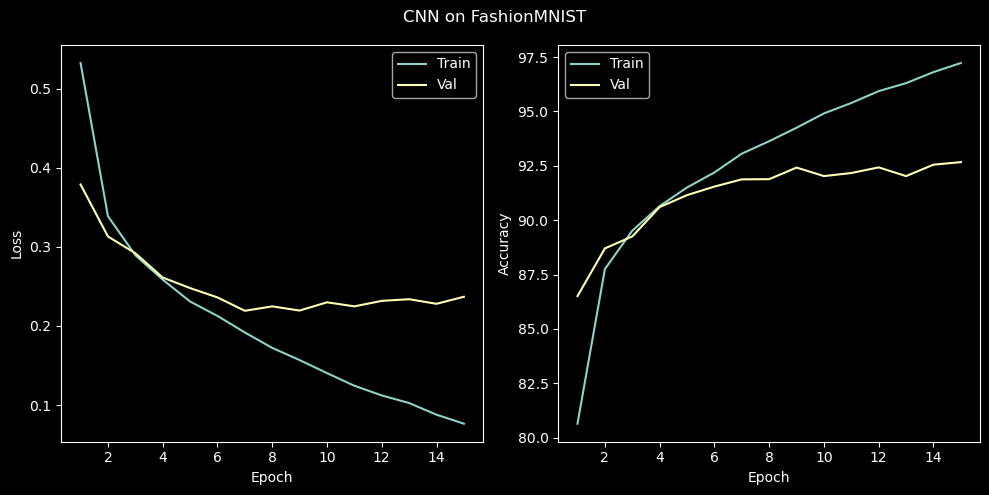

In [6]:

# Step 5: Plot the training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train')
plt.plot(range(1, num_epochs+1), val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle(f'{MODEL} on {dataset_name}')
plt.savefig(f'result/{MODEL}_{dataset_name}_BZ{BATCH_SIZE}.png')
plt.tight_layout()
plt.show()

In [7]:
# Step 6: Evaluate the model on the test set
test_total = 0
test_correct = 0

test_net = torch.load(best_model_path)
net.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = test_net(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_acc = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 92.29%


In [8]:
with open(f'result/{MODEL}_{dataset_name}_BZ{BATCH_SIZE}.txt', 'w') as file:
    file.write(str(net))
    file.write('\n')
    file.write("Test Accuracy: {test_acc:.2f}%")